In [1]:
from IPython.display import Image, display

from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery
from azure.core.credentials import AzureKeyCredential
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from pydantic import BaseModel
from typing import List, Dict, Any, Union, Literal, get_args, Set
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, START, END
from typing import Dict, Any, TypedDict, Set
from langsmith import traceable
from langgraph.constants import Send
import operator
import json

load_dotenv()

# Azure Search configuration
ai_search_endpoint = os.environ["AZURE_SEARCH_ENDPOINT"]
ai_search_key = os.environ["AZURE_SEARCH_KEY"]
ai_search_index = os.environ["AZURE_SEARCH_INDEX"]

# Azure OpenAI configuration
aoai_deployment = os.getenv("AOAI_DEPLOYMENT")
aoai_key = os.getenv("AOAI_KEY")
aoai_endpoint = os.getenv("AOAI_ENDPOINT")

search_client = SearchClient(ai_search_endpoint, ai_search_index, AzureKeyCredential(ai_search_key))
print("Index: ", ai_search_index)

MAX_ATTEMPTS = 3
NUM_SEARCH_RESULTS = 5
K_NEAREST_NEIGHBORS = 30

# Create a type for indices from 0 to NUM_SEARCH_RESULTS-1
SearchResultIndex = Literal[tuple(range(NUM_SEARCH_RESULTS))]

# Type Definitions
class SearchResult(TypedDict):
    id: str
    content: str
    source_file: str
    source_pages: int
    score: float

class ReviewDecision(BaseModel):
    """Schema for review agent decisions"""
    thought_process: str
    valid_results: List[SearchResultIndex]  # Indices of valid results
    invalid_results: List[SearchResultIndex]  # Indices of invalid results
    decision: Literal["retry", "finalize"]

class SearchPromptResponse(BaseModel):
    """Schema for search prompt responses"""
    search_query: str
    filter: str | None

class TaxonomyExtraction(BaseModel):
    """Schema for taxonomy extraction"""
    taxonomies: List[str]
    reasoning: str

# Main state for the overall workflow
class MainState(TypedDict):
    user_input: str
    taxonomies: List[str]
    research_results: List[Dict[str, Any]]
    final_answer: str | None
    thought_process: List[Dict[str, Any]]  # List of thought process steps
    # Add for consolidation with operator.add annotation
    research_outputs: List[Dict[str, Any]]

# Output state for research agents
class ResearchOutputState(TypedDict):
    taxonomy: str
    vetted_results: List[SearchResult]
    thought_process: List[Dict[str, Any]]

# State for individual research agents
class ResearchState(TypedDict):
    taxonomy: str
    user_input: str
    current_results: List[SearchResult]
    vetted_results: List[SearchResult]
    discarded_results: List[SearchResult]
    processed_ids: Set[str]  # Track all processed document IDs
    reviews: List[str]       # Thought processes from reviews
    decisions: List[str]     # Store the actual decisions
    attempts: int            # Track number of search attempts
    search_history: List[Dict[str, Any]]  # Track previous search queries and filters
    thought_process: List[Dict[str, Any]]  # List of thought process steps

# LLM Setup
llm = AzureChatOpenAI(
    azure_deployment=aoai_deployment,
    api_version="2024-05-01-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=aoai_key,
    azure_endpoint=aoai_endpoint
)

review_llm = llm.with_structured_output(ReviewDecision)
taxonomy_llm = llm.with_structured_output(TaxonomyExtraction)

embeddings_model = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-large",
    api_key=aoai_key,
    azure_endpoint=aoai_endpoint
)

def format_search_results(results: List[SearchResult]) -> str:
    """Format search results into a nicely formatted string."""
    output_parts = ["\n=== Search Results ==="]
    for i, result in enumerate(results, 0):
        result_parts = [
            f"\nResult #{i}",
            "=" * 80,
            f"ID: {result['id']}",
            f"Source File: {result['source_file']}",
            f"Source Pages: {result['source_pages']}",
            "\n<Start Content>",
            "-" * 80,
            result['content'],
            "-" * 80,
            "<End Content>"
        ]
        output_parts.extend(result_parts)
    formatted_output = "\n".join(output_parts)
    return formatted_output

@traceable(run_type="retriever", name="run_search")
def run_search(search_query: str, processed_ids: Set[str], category_filter: str | None = None) -> List[SearchResult]:
    """
    Perform a search using Azure Cognitive Search with both semantic and vector queries.
    """
    # Generate vector embedding for the query
    query_vector = embeddings_model.embed_query(search_query)
    vector_query = VectorizedQuery(
        vector=query_vector,
        k_nearest_neighbors=K_NEAREST_NEIGHBORS,
        fields="content_vector"
    )
    
    # Create filter combining processed_ids and category filter
    filter_parts = []
    if processed_ids:
        ids_string = ','.join(processed_ids)
        filter_parts.append(f"not search.in(id, '{ids_string}')")
    if category_filter:
        filter_parts.append(f"({category_filter})")
    filter_str = " and ".join(filter_parts) if filter_parts else None

    # Perform the search
    results = search_client.search(
        search_text=search_query,
        vector_queries=[vector_query],
        filter=filter_str,
        select=["id", "content", "source_file", "source_pages"],
        top=NUM_SEARCH_RESULTS
    )
    
    search_results = []
    for result in results:
        search_result = SearchResult(
            id=result["id"],
            content=result["content"],
            source_file=result["source_file"],
            source_pages=result["source_pages"],
            score=result["@search.score"]
        )
        search_results.append(search_result)
    
    return search_results

# Main graph functions
def identify_taxonomies(state: MainState) -> MainState:
    """Extract taxonomies from the user's question"""
    print('Identifying taxonomies from the question')
    
    taxonomy_prompt = """You are an expert at breaking down complex questions into distinct taxonomies or categories for research.
    
Given a user's question, identify the main taxonomies or categories that should be researched separately to provide a comprehensive answer.

For example:
- A question about "Compare AWS Lambda vs Azure Functions" might have taxonomies: "AWS Lambda Features", "Azure Functions Features", "Performance Comparison", "Pricing Models", "Integration Capabilities"
- A question about "What are the best practices for microservice architecture?" might have taxonomies: "Service Boundaries", "Communication Patterns", "Data Management", "Deployment Strategies", "Monitoring and Observability"

Provide 2-5 taxonomies depending on the complexity of the question. Each taxonomy should be a specific aspect that can be researched somewhat independently.

Your taxonomies should:
1. Cover the key aspects needed to fully answer the question
2. Be specific enough to guide focused research
3. Be distinct from each other to minimize overlap
4. Together provide comprehensive coverage of what's needed to answer the question

Return these taxonomies along with a brief reasoning explaining your choice of taxonomies.
"""
    
    messages = [
        {"role": "system", "content": taxonomy_prompt},
        {"role": "user", "content": f"Extract taxonomies from this question: {state['user_input']}"}
    ]
    
    taxonomy_response = taxonomy_llm.invoke(messages)
    state["taxonomies"] = taxonomy_response.taxonomies
    
    # Add to thought process
    state["thought_process"].append({
        "type": "taxonomy_extraction",
        "details": {
            "taxonomies": taxonomy_response.taxonomies,
            "reasoning": taxonomy_response.reasoning
        }
    })
    
    print(f"Identified taxonomies: {state['taxonomies']}")
    
    return state

def distribute_research_tasks(state: MainState) -> list:
    """Distribute research tasks to individual research agents based on taxonomies"""
    print(f"Distributing {len(state['taxonomies'])} research tasks to agents")
    
    return [
        Send("research_agent", {
            "taxonomy": taxonomy,
            "user_input": state["user_input"],
            "current_results": [],
            "vetted_results": [],
            "discarded_results": [],
            "processed_ids": set(),
            "reviews": [],
            "decisions": [],
            "attempts": 0,
            "search_history": [],
            "thought_process": []
        }) for taxonomy in state["taxonomies"]
    ]

def consolidate_results(state: MainState) -> MainState:
    """Consolidate results from all research agents"""
    print("Consolidating results from all research agents")
    
    # Extract results from research_outputs (matching report generator pattern)
    research_results = state["research_outputs"]
    
    # Add to thought process
    state["thought_process"].append({
        "type": "consolidation",
        "details": {
            "num_taxonomies": len(state["taxonomies"]),
            "results_per_taxonomy": {result["taxonomy"]: len(result["vetted_results"]) for result in research_results}
        }
    })
    
    # Store research results for final inference
    state["research_results"] = research_results
    
    return state

def final_inference(state: MainState) -> MainState:
    """Generate final answer by synthesizing all research results"""
    print("Generating final answer")
    
    final_prompt = """Create a comprehensive answer to the user's question by synthesizing the research conducted on different taxonomies.

User Question: {question}

Research Results:
{research_results}

Generate a clear, coherent answer that integrates information from all taxonomies and provides a complete response to the user's question. 
Ensure the answer is well-structured and flows naturally between different aspects of the research.
Cite specific results when appropriate.
Do not include any information about the research process or taxonomies in your answer.
"""
    
    # Format research results for the prompt
    formatted_results = ""
    for result in state["research_results"]:
        formatted_results += f"\n=== Taxonomy: {result['taxonomy']} ===\n"
        if result["vetted_results"]:
            for i, res in enumerate(result["vetted_results"]):
                formatted_results += f"Result {i+1}: {res['content']}\n"
        else:
            formatted_results += "No relevant results found for this taxonomy.\n"
    
    messages = [
        {"role": "system", "content": final_prompt},
        {"role": "user", "content": final_prompt.format(
            question=state["user_input"],
            research_results=formatted_results
        )}
    ]
    
    response_chunks = []
    for chunk in llm.stream(messages):
        response_chunks.append(chunk.content)
        print(chunk.content, end="", flush=True)
    
    final_answer = "".join(response_chunks)
    state["final_answer"] = final_answer
    
    # Add to thought process
    state["thought_process"].append({
        "type": "final_answer",
        "details": {
            "final_answer": final_answer
        }
    })
    
    return state

# Research agent functions
def generate_search_query(state: ResearchState) -> ResearchState:
    """Generate an optimized search query based on the current state"""
    print(f'Generating search query for taxonomy: {state["taxonomy"]}')
    state["attempts"] += 1
    
    query_prompt = """Generate an effective search query for retrieving information on a specific taxonomy related to the user's question.

User Question: {question}
Taxonomy: {taxonomy}

Your task is to create a targeted search query and optional filter that will retrieve documents specifically relevant to this taxonomy.

Search queries should:
1. Be specific and focused on the taxonomy
2. Include key terms and concepts relevant to the taxonomy
3. Be concise but descriptive
4. Be tailored to retrieve factual information

If there have been previous search attempts, review them and adjust your strategy accordingly.

Previous Search Attempts:
{search_history}

Return:
1. search_query: Your optimized search query
2. filter: An optional filter to narrow results (can be None)
"""
    
    search_history_formatted = ""
    if state["search_history"]:
        search_history_formatted = "\n### Previous Search Attempts ###\n"
        for i, (search, review) in enumerate(zip(state["search_history"], state["reviews"]), 1):
            search_history_formatted += f"<Attempt {i}>\n"
            search_history_formatted += f"   Query: {search['query']}\n"
            search_history_formatted += f"   Filter: {search['filter']}\n"
            search_history_formatted += f"   Review: {review}\n"
    
    llm_input = query_prompt.format(
        question=state["user_input"],
        taxonomy=state["taxonomy"],
        search_history=search_history_formatted
    )
    
    messages = [
        {"role": "system", "content": "You are an expert search query generator."},
        {"role": "user", "content": llm_input}
    ]
    
    llm_with_search_prompt = llm.with_structured_output(SearchPromptResponse)
    search_response = llm_with_search_prompt.invoke(messages)
    
    # Record this search query in history
    state["search_history"].append({
        "query": search_response.search_query,
        "filter": search_response.filter
    })
    
    # Run the search
    current_results = run_search(
        search_query=search_response.search_query,
        processed_ids=state["processed_ids"],
        category_filter=search_response.filter
    )
    state["current_results"] = current_results
    
    # Add to thought process
    state["thought_process"].append({
        "type": "search_query",
        "details": {
            "taxonomy": state["taxonomy"],
            "query": search_response.search_query,
            "filter": search_response.filter,
            "num_results": len(current_results)
        }
    })
    
    return state

def review_results(state: ResearchState) -> ResearchState | ResearchOutputState:
    """Review current results and categorize them as valid or invalid.
    When review decision is 'finalize', return the final output directly."""
    print(f'Reviewing search results for taxonomy: {state["taxonomy"]}')
    
    review_prompt = """Review these search results and determine which contain relevant information for answering the user's question within the specific taxonomy.

User Question: {question}
Taxonomy: {taxonomy}

Your task is to evaluate each search result and determine if it contains information that helps address this taxonomy of the user's question.

Consider:
1. Does the result contain information relevant to this specific taxonomy?
2. Does the information help answer the user's question from the perspective of this taxonomy?
3. Is the information factual and reliable?

Respond with:
1. thought_process: Your analysis of each result
2. valid_results: List of indices (0-N) for useful results
3. invalid_results: List of indices (0-N) for irrelevant results
4. decision: Either "retry" if we need more info or "finalize" if we have sufficient information

Current Search Results:
{current_results}

Previously Vetted Results:
{vetted_results}

Search History:
{search_history}
"""
    
    current_results_formatted = format_search_results(state["current_results"]) if state["current_results"] else "No current results."
    vetted_results_formatted = format_search_results(state["vetted_results"]) if state["vetted_results"] else "No previously vetted results."
    
    search_history_formatted = ""
    if state["search_history"]:
        search_history_formatted = "\n### Search History ###\n"
        for i, (search, review) in enumerate(zip(state["search_history"], state["reviews"]), 1):
            search_history_formatted += f"<Attempt {i}>\n"
            search_history_formatted += f"   Query: {search['query']}\n"
            search_history_formatted += f"   Filter: {search['filter']}\n"
            search_history_formatted += f"   Review: {review}\n"
    
    llm_input = review_prompt.format(
        question=state["user_input"],
        taxonomy=state["taxonomy"],
        current_results=current_results_formatted,
        vetted_results=vetted_results_formatted,
        search_history=search_history_formatted
    )
    
    messages = [
        {"role": "system", "content": "You are an expert at evaluating search results."},
        {"role": "user", "content": llm_input}
    ]
    
    review = review_llm.invoke(messages)
    
    # Add to thought process
    state["thought_process"].append({
        "type": "review",
        "details": {
            "taxonomy": state["taxonomy"],
            "thought_process": review.thought_process,
            "decision": review.decision,
            "valid_results": len(review.valid_results),
            "invalid_results": len(review.invalid_results)
        }
    })
    
    state["reviews"].append(review.thought_process)
    state["decisions"].append(review.decision)
    
    for idx in review.valid_results:
        result = state["current_results"][idx]
        state["vetted_results"].append(result)
        state["processed_ids"].add(result["id"])
    
    for idx in review.invalid_results:
        result = state["current_results"][idx]
        state["discarded_results"].append(result)
        state["processed_ids"].add(result["id"])
    
    state["current_results"] = []
    
    # If maximum attempts reached or decision is finalize, return the final output
    if review.decision == "finalize" or state["attempts"] >= MAX_ATTEMPTS:
        print(f"Finalizing research for taxonomy: {state['taxonomy']}")
        # Return the appropriate subset of state as ResearchOutputState
        return ResearchOutputState(
            taxonomy=state["taxonomy"],
            vetted_results=state["vetted_results"],
            thought_process=state["thought_process"]
        )
    
    # Otherwise, continue with the research loop
    return state

def review_router(state: ResearchState) -> str:
    """Route to either retry search or go to END (finalize happens in review_results now)"""
    if state["attempts"] >= MAX_ATTEMPTS:
        print(f"\nReached maximum attempts ({MAX_ATTEMPTS}) for taxonomy {state['taxonomy']}. Proceeding to finalize.")
        return "finalize"
    
    latest_decision = state["decisions"][-1]
    if latest_decision == "finalize":
        return "finalize"
    
    return "retry"

# Build research agent graph
def build_research_graph():
    """Build the research agent workflow graph"""
    builder = StateGraph(ResearchState, output=ResearchOutputState)
    
    # Add nodes
    builder.add_node("generate_search_query", generate_search_query)
    builder.add_node("review_results", review_results)
    
    # Add edges
    builder.add_edge(START, "generate_search_query")
    builder.add_edge("generate_search_query", "review_results")
    
    # Add conditional edges based on review outcome
    builder.add_conditional_edges(
        "review_results",
        review_router,
        {
            "retry": "generate_search_query",
            "finalize": END
        }
    )
    
    return builder.compile()

# Build main graph
def build_main_graph():
    """Build the main workflow graph"""
    # Initialize with research_outputs field using operator.add annotation
    builder = StateGraph(MainState)
    builder.add_node("identify_taxonomies", identify_taxonomies)
    builder.add_node("research_agent", build_research_graph())
    builder.add_node("consolidate_results", consolidate_results)
    builder.add_node("final_inference", final_inference)
    
    # Using the same pattern as the report builder
    builder.add_edge(START, "identify_taxonomies")
    builder.add_conditional_edges(
        "identify_taxonomies",
        distribute_research_tasks,
        ["research_agent"]
    )
    
    # Following the report builder pattern for research outputs
    builder.set_field("research_outputs", merge_fn=operator.add, default=[])
    
    builder.add_edge("research_agent", "consolidate_results")
    builder.add_edge("consolidate_results", "final_inference")
    builder.add_edge("final_inference", END)
    
    return builder.compile()

if __name__ == "__main__":
    # Initialize graph
    graph = build_main_graph()
    
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

    # while True:
    #     user_input = input("Enter your question (or 'quit' to exit): ").strip()
    #     if user_input.lower() == 'quit':
    #         print("Exiting system...")
    #         break
        
    #     if not user_input:
    #         print("Please enter a valid question.")
    #         continue
        
    #     # Initialize state
    #     initial_state = MainState(
    #         user_input=user_input,
    #         taxonomies=[],
    #         research_results=[],
    #         research_outputs=[],
    #         final_answer=None,
    #         thought_process=[]
    #     )
        
    #     final_state = graph.invoke(initial_state)
        
    #     if final_state["final_answer"]:
    #         # Build the final payload to return via your API
    #         final_payload = {
    #             "final_answer": final_state["final_answer"],
    #             "taxonomies": final_state["taxonomies"],
    #             "research_results": final_state["research_results"],
    #             "thought_process": final_state["thought_process"]
    #         }
            
    #         # For demonstration purposes, we're printing the payload
    #         print("\n=== API Return Payload ===")
    #         print(json.dumps(final_payload, indent=2))
    #     else:
    #         print("\nUnable to find a satisfactory answer.")

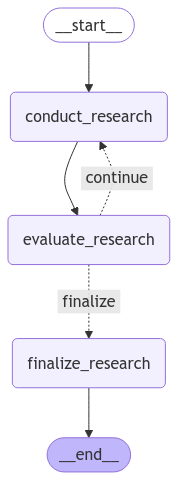

In [2]:
builder = StateGraph(ResearchState)
builder.add_node("conduct_research", conduct_research)
builder.add_node("evaluate_research", evaluate_research)
builder.add_node("finalize_research", finalize_research)

builder.add_edge(START, "conduct_research")
builder.add_edge("conduct_research", "evaluate_research")

builder.add_conditional_edges(
    "evaluate_research",
    review_router,
    {
        "continue": "conduct_research",
        "finalize": "finalize_research"
    }
)

builder.add_edge("finalize_research", END)

research_agent = builder.compile()


display(Image(research_agent.get_graph(xray=1).draw_mermaid_png()))

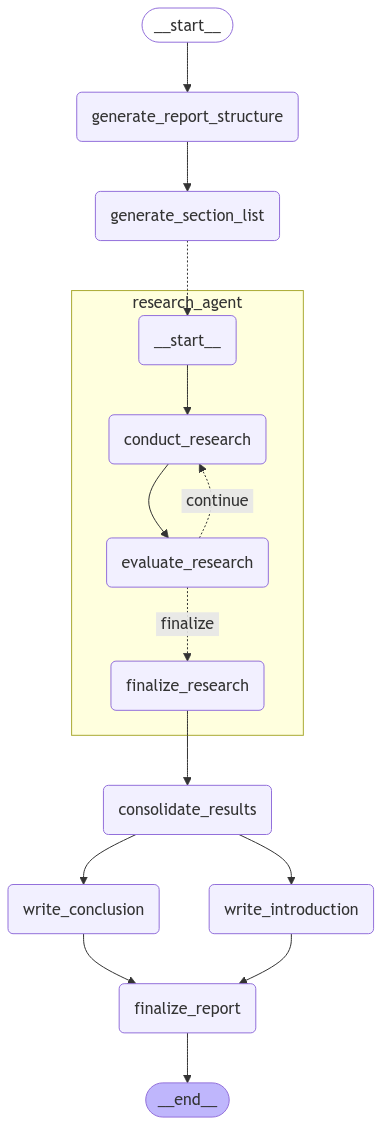

In [14]:
# Report Graph
main_graph_builder = StateGraph(ReportState)

main_graph_builder.add_node("generate_report_structure", generate_report_structure)
main_graph_builder.add_node("generate_section_list", generate_section_list)
main_graph_builder.add_node("research_agent", builder.compile())
main_graph_builder.add_node("consolidate_results", consolidate_results)
main_graph_builder.add_node("write_introduction", write_introduction)
main_graph_builder.add_node("write_conclusion", write_conclusion)
main_graph_builder.add_node("finalize_report", finalize_report)


# Add edges
main_graph_builder.add_edge(START, "generate_report_structure")
main_graph_builder.add_edge("generate_report_structure", "generate_section_list")
main_graph_builder.add_conditional_edges("generate_section_list", distribute_sections, ["research_agent"])
main_graph_builder.add_edge("research_agent", "consolidate_results")
main_graph_builder.add_edge("consolidate_results", "write_introduction")
main_graph_builder.add_edge("consolidate_results", "write_conclusion")
main_graph_builder.add_edge("write_introduction", "finalize_report")
main_graph_builder.add_edge("write_conclusion", "finalize_report")
main_graph_builder.add_edge("finalize_report", END)
graph = main_graph_builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))